In [1]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
from steam import WebAPI
import os
import glob
import tensorflow as tf
import requests
from sklearn import decomposition
import umap
#import logging
#logging.getLogger("tensorflow").setLevel(logging.ERROR)

#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

#dont keep api key in github!!!
api_file = os.path.join('..','..','..','apikeys','steam_api_key.txt')
with open(api_file, 'r') as fin:
    api = WebAPI(key=fin.readline())

print(tf.__version__)

2.0.0


In [2]:
sns.set_style('ticks')

In [3]:
#declare interface urls
#dota2_beta should be used for testing in order to not aggressively make API requests
dota2_id = '570'
dota2_beta_id = '205790'

hero_list = api.call('IEconDOTA2_'+dota2_id+'.GetHeroes')
hero_vocab=[int(hero_id['id']) for hero_id in hero_list['result']['heroes']] 
print(len(hero_vocab))

117


# Load embedding from tmp_log_dir or log_dir

In [115]:
#if you know the log_dir of a specific embedding
logdir = os.path.join('..','..','..',
                      'tmp_log_dir',
                      '20191029-164616',
                      'embedding.npy')
#logdir = os.path.join('log_dir',
#                        '20191029-164616',
#                        'embedding.npy')

In [4]:
#if you don't know the log_dir of embedding or
#  you want to get multiple embeddings use glob

#paths=glob.glob(os.path.join('..','..','..',
#                             'tmp_log_dir','*'))
paths=glob.glob(os.path.join('log_dir','*'))
paths.sort(key=os.path.getmtime)

#load most recent embedding
embedding = np.load(os.path.join(paths[0],
                                 'embedding.npy'))

#load all embeddings in logdir
embedding_dict = {}
for path in paths:
    #15 characters are in the datetime stamp
    #  of the log folders
    embedding_dict[path[-15:]]=np.load(
                            os.path.join(
                            path,'embedding.npy'))
print(len(paths))

23


In [5]:
reducer=umap.UMAP(
                n_neighbors=15,
                min_dist=0.1,
                metric='euclidean')

In [6]:
#umap_embedding = reducer.fit_transform(embedding)

umap_embed={}
for name,embed in embedding_dict.items():
    umap_embed[name] = reducer.fit_transform(embed)

In [7]:
pca = decomposition.PCA(n_components=5)
#pca_embedding = pca.fit_transform(embedding)

pca_embed={}
for name,embed in embedding_dict.items():
    pca_embed[name] = pca.fit_transform(embed)

In [8]:
embed_array = np.array(list(pca_embed.values()))
embed_ave= np.average(embed_array,axis=0)
embed_std= np.std(embed_array,axis=0)
print(np.average(embed_std))
print(np.average(np.abs(embed_ave)))
umap_embed_ave=reducer.fit_transform(embed_ave)

0.027515355
0.0047266847


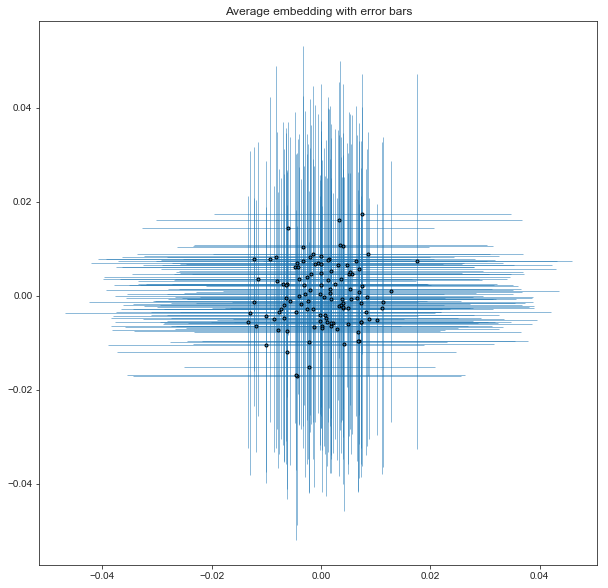

In [9]:
fix,ax = plt.subplots(1,1,figsize=(10,10))
ax.errorbar(embed_ave[:,0],embed_ave[:,1],
             embed_std[:,0],embed_std[:,1,],
             elinewidth=0.5,mec='k',
             marker='.',linewidth=0)
ax.set_title('Average embedding with error bars')
plt.show()

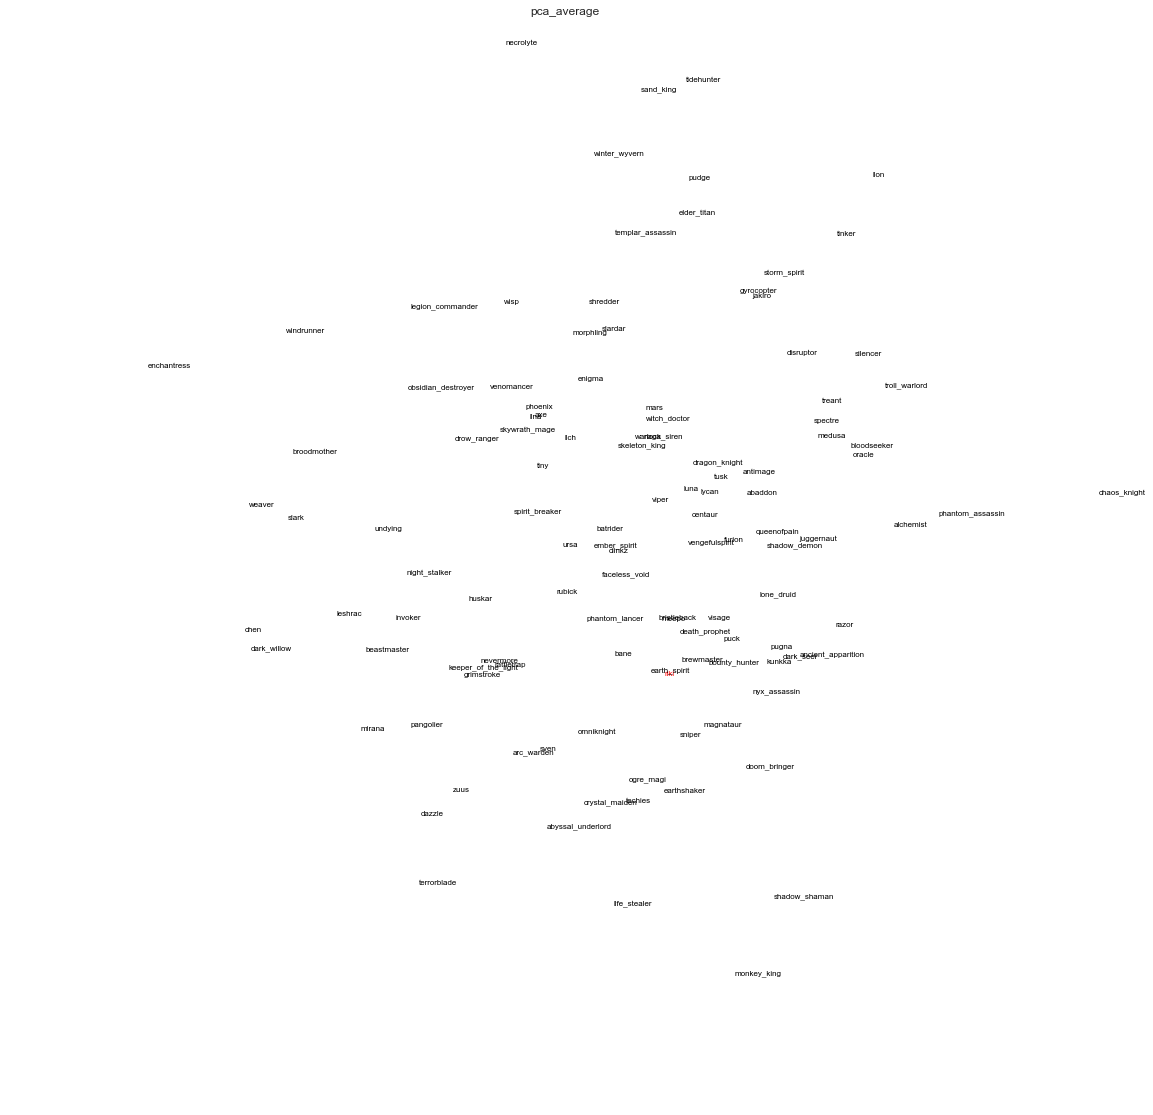

In [152]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
embed = embed_ave
for vec,hero in zip(embed,hero_list['result']['heroes']):
    if hero['name'][14:]=='riki':
        font_dict = {'color': 'red',
                         'size': 8}
    else:
        font_dict = {'color': 'black',
                         'size': 8}
        
    ax.text(vec[0],vec[1],hero['name'][14:],fontdict=font_dict)
    
xmin = min(embed[:,0])
xmax = max(embed[:,0])
ymin = min(embed[:,1])
ymax = max(embed[:,1])
ax.set_xlim(xmin*1.3,xmax*1.05)
ax.set_ylim(ymin*1.3,ymax*1.05)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
ax.set_title(label='pca_average')
plt.show()

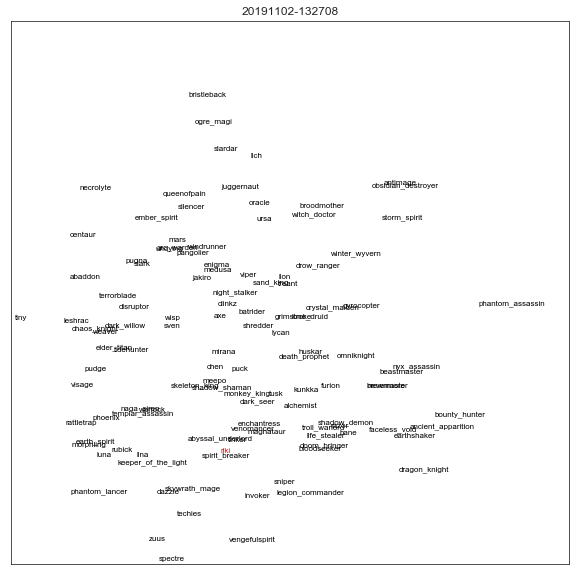

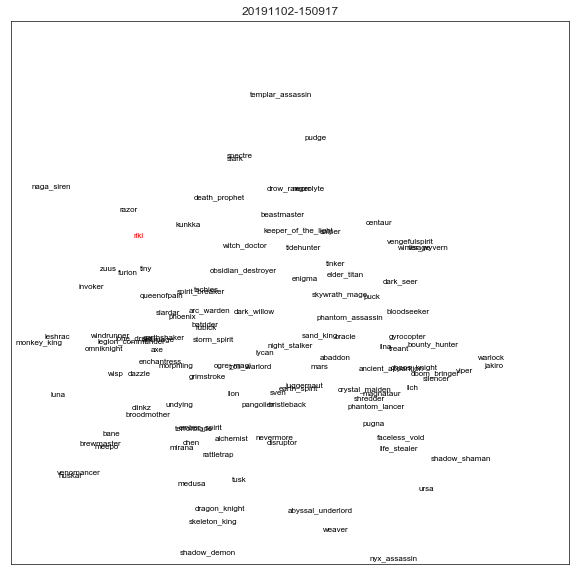

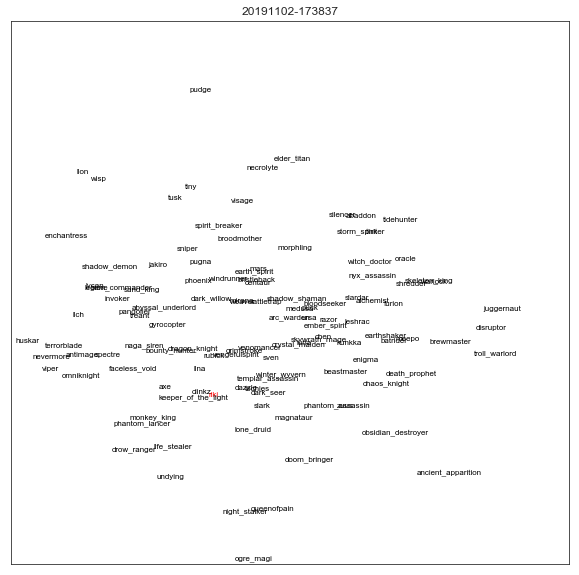

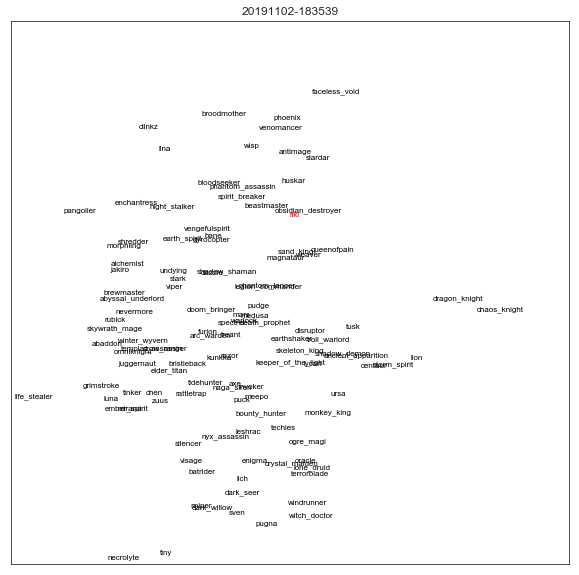

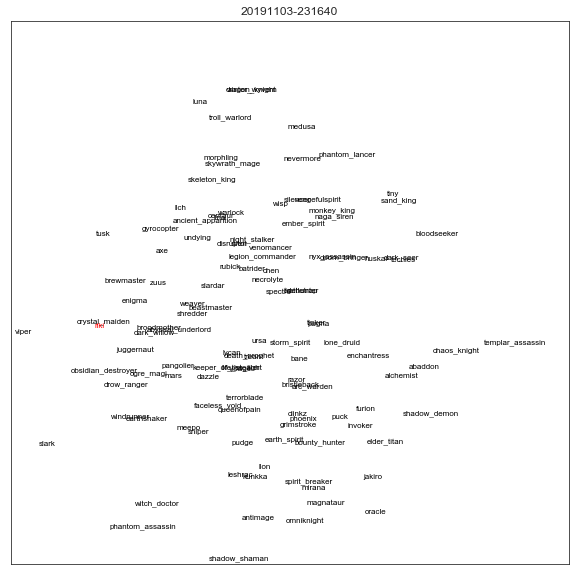

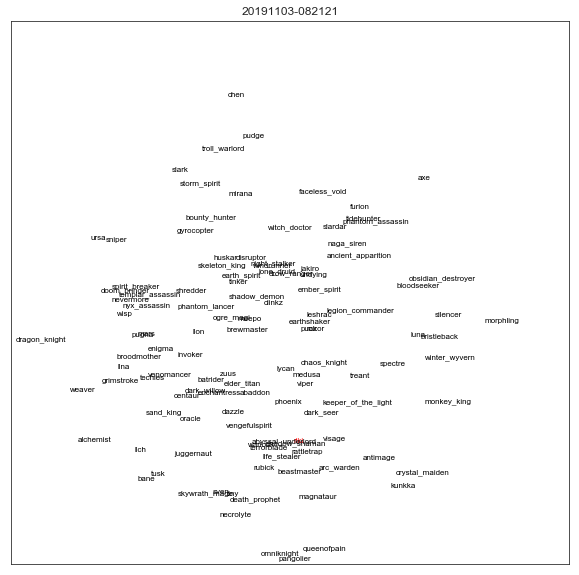

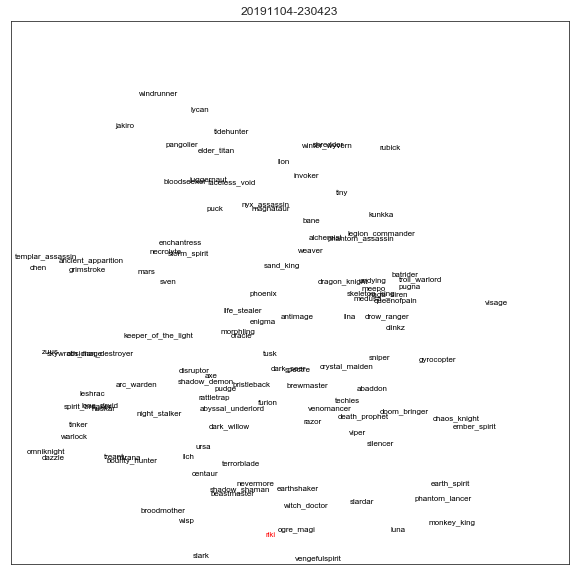

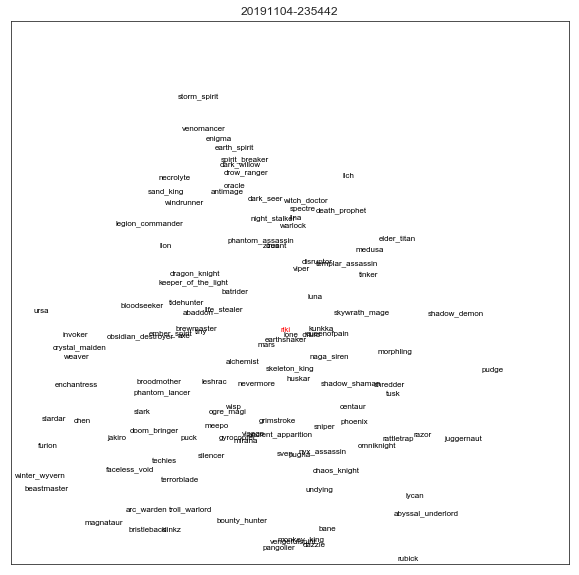

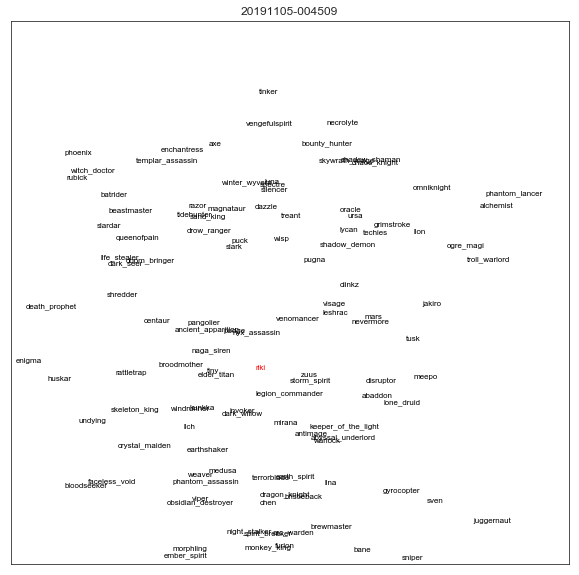

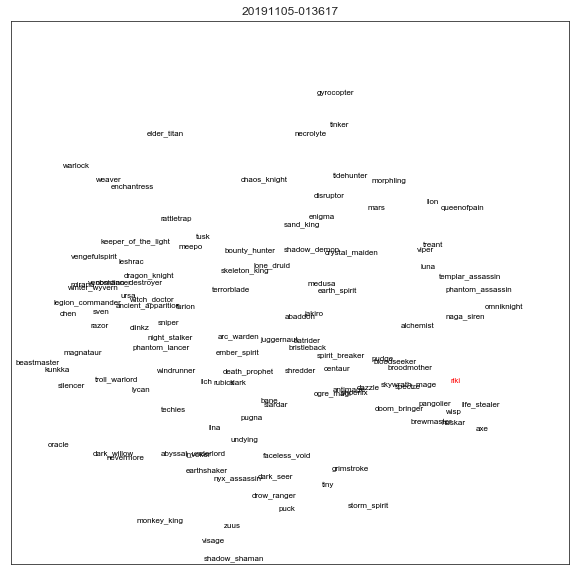

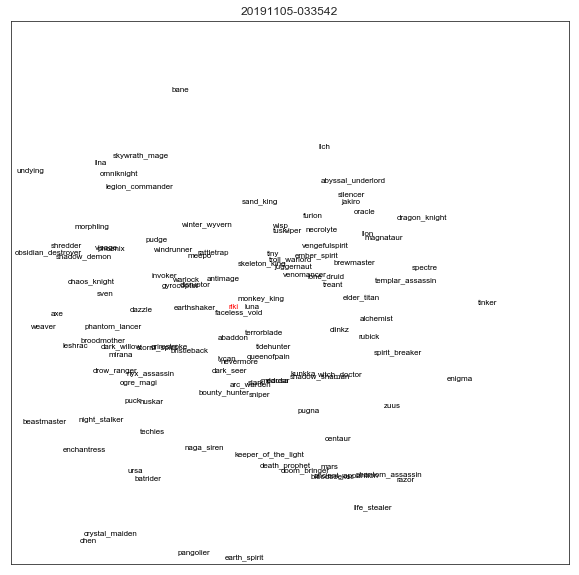

In [132]:
for name, embedding in pca_embed.items():
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    
    for vec,hero in zip(embedding,hero_list['result']['heroes']):
        if hero['name'][14:]=='riki':
            font_dict = {'color': 'red',
                         'size': 8}
        else:
            font_dict = {'color': 'black',
                         'size': 8}
        
        ax.text(vec[0],vec[1],hero['name'][14:],fontdict=font_dict)
    
    xmin = min(embedding[:,0])
    xmax = max(embedding[:,0])
    ymin = min(embedding[:,1])
    ymax = max(embedding[:,1])
    ax.set_xlim(xmin*1.02,xmax*1.35)
    ax.set_ylim(ymin*1.02,ymax*1.3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(label=name)
    plt.show()

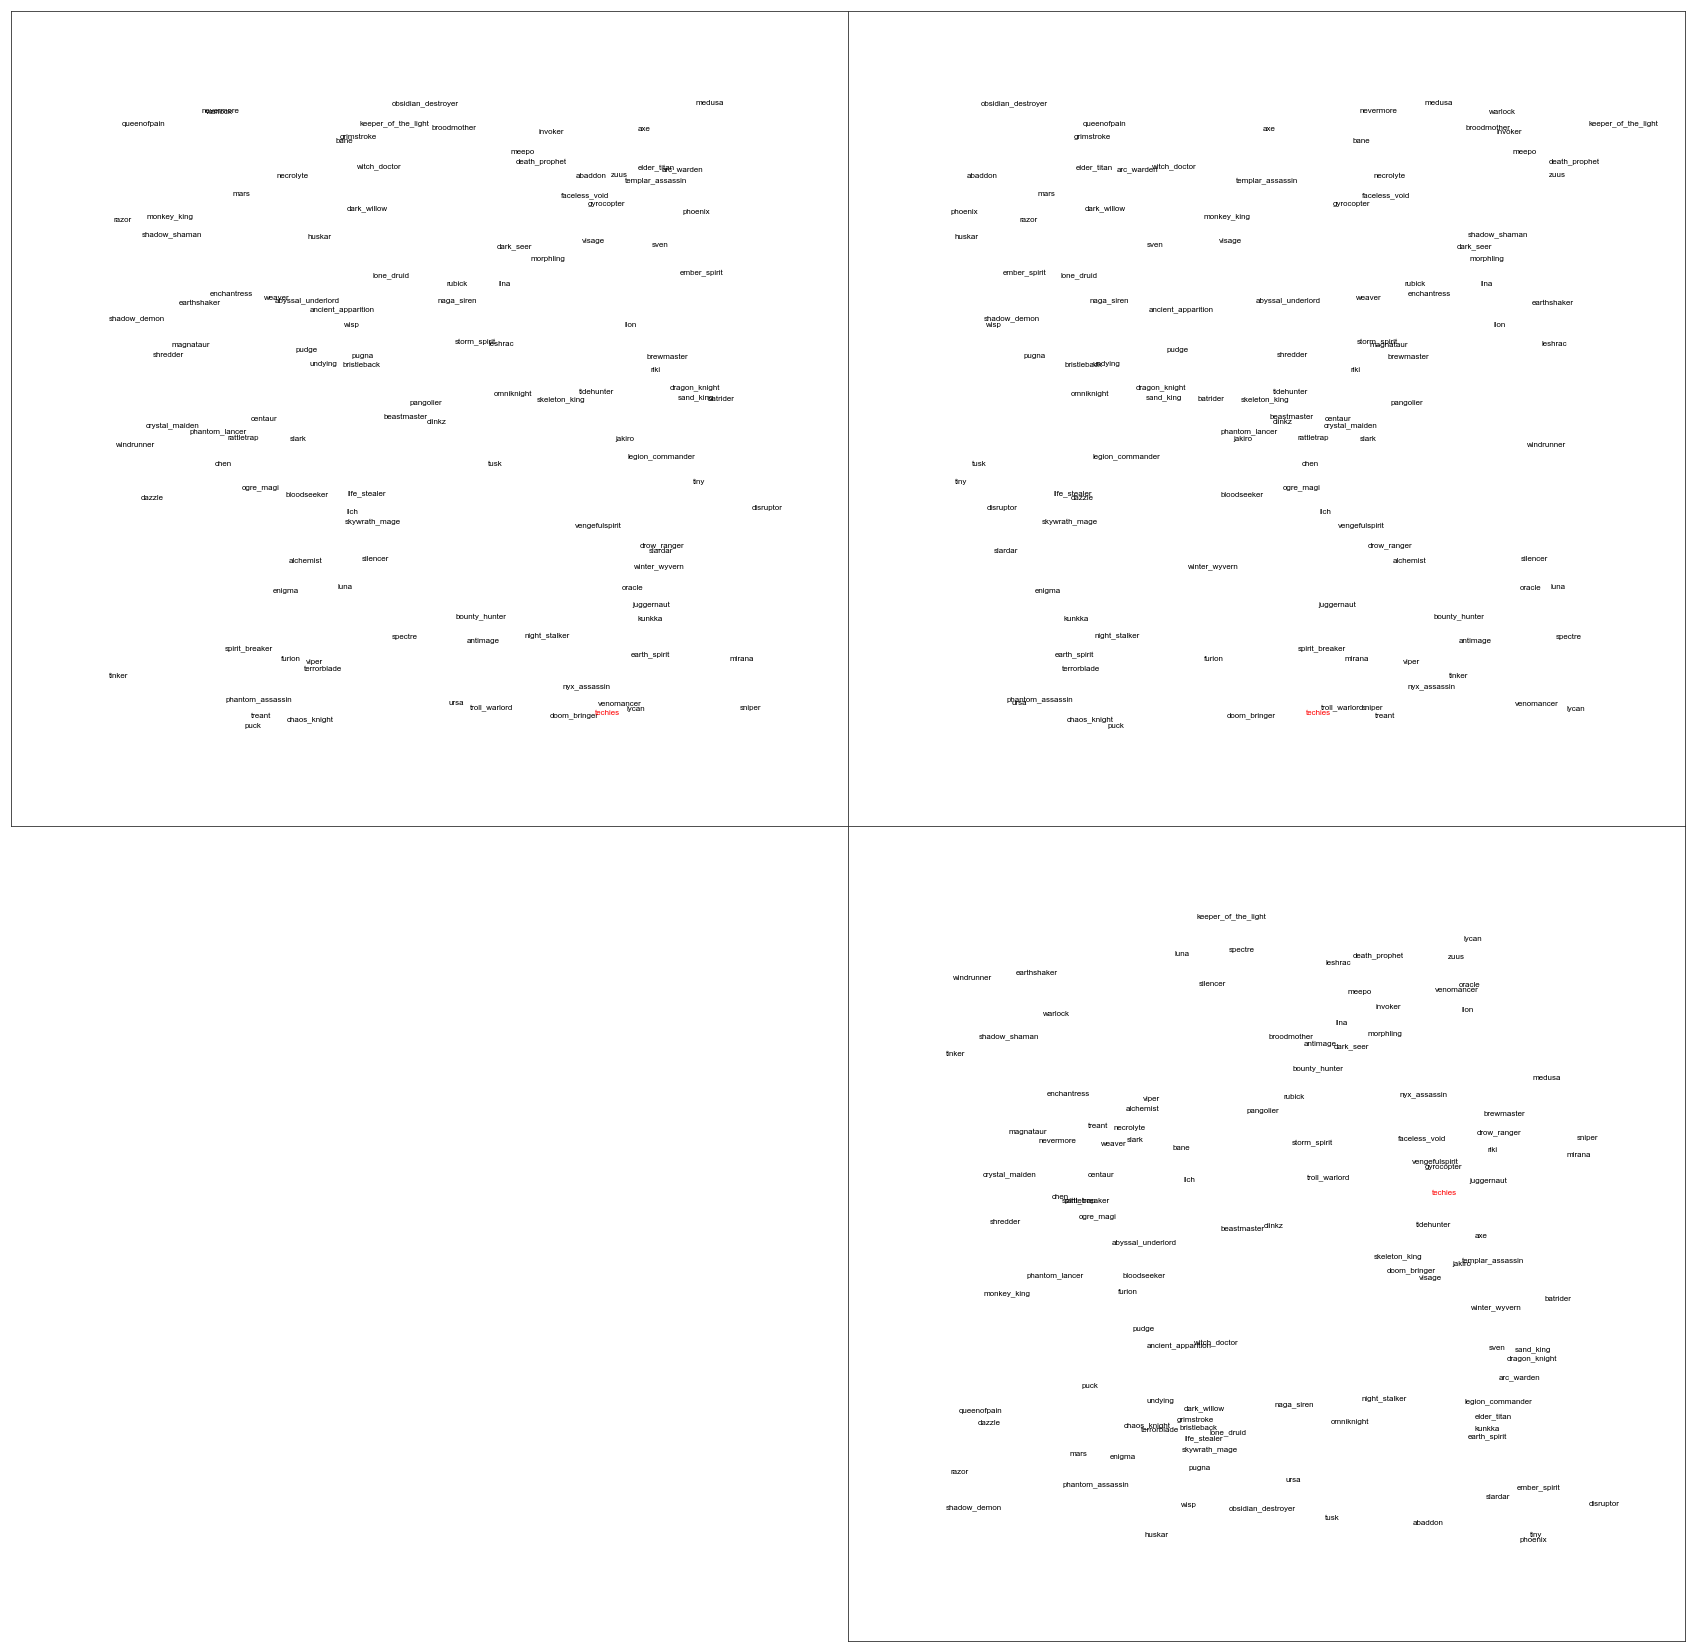

In [26]:
fig, ax = plt.subplots(2,2,figsize=(30,30))

plot_range = 1.3*max(embedding[:,0])

for vec,hero in zip(embedding,hero_list['result']['heroes']):
    if hero['name'][14:]=='techies':
        font_dict = {'color': 'red',
                     'size': 8}
    else:
        font_dict = {'color': 'black',
                     'size': 8}
    
    ax[0,0].text(vec[1],vec[0],hero['name'][14:],fontdict=font_dict)
    ax[0,1].text(vec[2],vec[0],hero['name'][14:],fontdict=font_dict)
    ax[1,1].text(vec[1],vec[2],hero['name'][14:],fontdict=font_dict)
    ax[1,0].axis('off')
# Do a little setup to make sure the plot displays nicely.
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xlim([-plot_range,plot_range])
        ax[i,j].set_ylim([-plot_range,plot_range])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        
plt.subplots_adjust(wspace=0, hspace=0)
plt.show() 